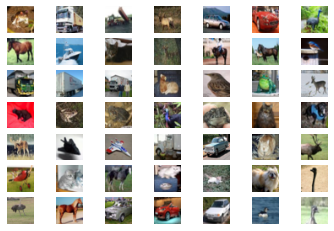

In [47]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

(trainX, trainy), (testX, testy) = load_data()
for i in range(49):
  pyplot.subplot(7, 7, 1+i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i])
pyplot.show()

In [48]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'ML/DCGAN/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#imports for Keras
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.layers import Dense, Conv2D, Flatten, Dropout,  LeakyReLU, Reshape, Conv2DTranspose
from keras.utils.vis_utils import plot_model

from numpy.random import rand, randn, randint
from numpy import hstack, zeros, ones
from matplotlib import pyplot

In [50]:
def load_real_samples():
  (trainX,_), (_,_) = load_data()
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5
  return X

def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y

In [51]:
def define_discriminator(in_shape = (32, 32, 3)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same', input_shape= in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [52]:
def define_generator(latent_dim):
  model = Sequential()
  #4x4
  model.add(Dense(256*4*4, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  #16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  #32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [53]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [54]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(n_samples * latent_dim)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [55]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  #predict output
  X = generator.predict(x_input)
  #plot result
  y = zeros((n_samples,1))
  return X, y

In [56]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 200, n_batch = 128, n_eval = 10):
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      # generate real/fake points
      x_real, y_real = generate_real_samples(dataset, half_batch)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # train discriminator
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      # generate latent points
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch,1))
      # train gan/generator
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      # evaluate
      if(j+1) % 100 == 0:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    if(i + 1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [57]:
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    pyplot.subplot(n, n, 1+i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])

  filename = '/content/drive/My Drive/ML/DCGAN/generated_plot_e%03d.png' % (epoch + 1)
  pyplot.savefig(filename)
  pyplot.close()

In [58]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  x_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)

  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))\

  save_plot(x_fake, epoch)

  filename = '/content/drive/My Drive/ML/DCGAN/generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [60]:
from keras.models import load_model

latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 100/390, d1=0.313, d2=0.209 g=4.543
>1, 200/390, d1=0.227, d2=0.284 g=3.056
>1, 300/390, d1=0.374, d2=0.330 g=1.996
>2, 100/390, d1=0.593, d2=0.606 g=1.321
>2, 200/390, d1=0.489, d2=0.472 g=1.151
>2, 300/390, d1=0.945, d2=0.445 g=1.889
>3, 100/390, d1=0.671, d2=0.465 g=1.473
>3, 200/390, d1=0.597, d2=0.473 g=1.445
>3, 300/390, d1=0.632, d2=0.507 g=1.240
>4, 100/390, d1=0.758, d2=0.493 g=1.336
>4, 200/390, d1=0.433, d2=0.500 g=1.340
>4, 300/390, d1=0.519, d2=0.493 g=1.315
>5, 100/390, d1=0.600, d2=0.507 g=1.204
>5, 200/390, d1=0.768, d2=0.577 g=1.381
>5, 300/390, d1=0.817, d2=0.452 g=1.303
>6, 100/390, d1=0.489, d2=0.563 g=1.306
>6, 200/390, d1=0.788, d2=0.665 g=1.325
>6, 300/390, d1=0.537, d2=0.689 g=1.096
>7, 100/390, d1=0.626, d2=0.583 g=1.221
>7, 200/390, d1=0.412, d2=0.479 g=1.693
>7, 300/390, d1=0.682, d2=0.498 g=1.089
>8, 100/390, d1=0.566, d2=0.632 g=1.163
>8, 200/390, d1=0.656, d2=0.665 g=1.133
>8, 300/390, d1=0.740, d2=0.509 g=1.179
>9, 100/390, d1=0.585, d2=0.579 g=1.162


>11, 100/390, d1=0.584, d2=0.515 g=1.075
>11, 200/390, d1=0.581, d2=0.475 g=1.186
>11, 300/390, d1=0.523, d2=0.633 g=1.252
>12, 100/390, d1=0.499, d2=0.613 g=1.055
>12, 200/390, d1=0.575, d2=0.616 g=1.122
>12, 300/390, d1=0.679, d2=0.666 g=0.947
>13, 100/390, d1=0.595, d2=0.640 g=1.018
>13, 200/390, d1=0.599, d2=0.701 g=0.860
>13, 300/390, d1=0.598, d2=0.629 g=0.984
>14, 100/390, d1=0.586, d2=0.607 g=0.917
>14, 200/390, d1=0.627, d2=0.696 g=0.833
>14, 300/390, d1=0.630, d2=0.667 g=0.868
>15, 100/390, d1=0.748, d2=0.603 g=0.939
>15, 200/390, d1=0.602, d2=0.486 g=1.126
>15, 300/390, d1=0.733, d2=0.573 g=1.020
>16, 100/390, d1=0.667, d2=0.574 g=0.935
>16, 200/390, d1=0.640, d2=0.643 g=0.883
>16, 300/390, d1=0.561, d2=0.739 g=0.856
>17, 100/390, d1=0.557, d2=0.758 g=0.886
>17, 200/390, d1=0.644, d2=0.626 g=0.841
>17, 300/390, d1=0.564, d2=0.634 g=0.942
>18, 100/390, d1=0.663, d2=0.739 g=0.767
>18, 200/390, d1=0.690, d2=0.617 g=0.944
>18, 300/390, d1=0.625, d2=0.623 g=0.867
>19, 100/390, d1

>21, 100/390, d1=0.650, d2=0.669 g=0.849
>21, 200/390, d1=0.660, d2=0.641 g=0.820
>21, 300/390, d1=0.692, d2=0.708 g=0.843
>22, 100/390, d1=0.697, d2=0.658 g=0.788
>22, 200/390, d1=0.600, d2=0.611 g=0.866
>22, 300/390, d1=0.696, d2=0.658 g=0.810
>23, 100/390, d1=0.698, d2=0.637 g=0.900
>23, 200/390, d1=0.666, d2=0.637 g=0.847
>23, 300/390, d1=0.636, d2=0.848 g=0.790
>24, 100/390, d1=0.676, d2=0.614 g=0.857
>24, 200/390, d1=0.619, d2=0.696 g=0.888
>24, 300/390, d1=0.615, d2=0.660 g=0.786
>25, 100/390, d1=0.693, d2=0.650 g=0.853
>25, 200/390, d1=0.678, d2=0.615 g=0.837
>25, 300/390, d1=0.687, d2=0.644 g=0.847
>26, 100/390, d1=0.716, d2=0.607 g=0.876
>26, 200/390, d1=0.633, d2=0.655 g=0.860
>26, 300/390, d1=0.659, d2=0.658 g=0.814
>27, 100/390, d1=0.705, d2=0.668 g=0.831
>27, 200/390, d1=0.680, d2=0.651 g=0.928
>27, 300/390, d1=0.679, d2=0.650 g=0.833
>28, 100/390, d1=0.687, d2=0.627 g=0.796
>28, 200/390, d1=0.654, d2=0.615 g=0.794
>28, 300/390, d1=0.647, d2=0.691 g=0.822
>29, 100/390, d1

>31, 100/390, d1=0.668, d2=0.730 g=0.801
>31, 200/390, d1=0.590, d2=0.676 g=0.853
>31, 300/390, d1=0.689, d2=0.677 g=0.834
>32, 100/390, d1=0.662, d2=0.627 g=0.823
>32, 200/390, d1=0.670, d2=0.606 g=0.877
>32, 300/390, d1=0.681, d2=0.667 g=0.824
>33, 100/390, d1=0.708, d2=0.643 g=0.842
>33, 200/390, d1=0.678, d2=0.663 g=0.816
>33, 300/390, d1=0.635, d2=0.690 g=0.800
>34, 100/390, d1=0.640, d2=0.617 g=0.822
>34, 200/390, d1=0.683, d2=0.632 g=0.850
>34, 300/390, d1=0.670, d2=0.605 g=0.919
>35, 100/390, d1=0.698, d2=0.619 g=0.869
>35, 200/390, d1=0.689, d2=0.647 g=0.796
>35, 300/390, d1=0.719, d2=0.650 g=0.850
>36, 100/390, d1=0.660, d2=0.658 g=0.799
>36, 200/390, d1=0.663, d2=0.670 g=0.832
>36, 300/390, d1=0.678, d2=0.691 g=0.822
>37, 100/390, d1=0.675, d2=0.614 g=0.856
>37, 200/390, d1=0.655, d2=0.713 g=0.760
>37, 300/390, d1=0.715, d2=0.642 g=0.839
>38, 100/390, d1=0.673, d2=0.698 g=0.797
>38, 200/390, d1=0.671, d2=0.647 g=0.847
>38, 300/390, d1=0.678, d2=0.550 g=0.865
>39, 100/390, d1

>41, 100/390, d1=0.677, d2=0.673 g=0.804
>41, 200/390, d1=0.613, d2=0.674 g=0.798
>41, 300/390, d1=0.641, d2=0.718 g=0.796
>42, 100/390, d1=0.726, d2=0.647 g=0.810
>42, 200/390, d1=0.626, d2=0.715 g=0.790
>42, 300/390, d1=0.686, d2=0.646 g=0.799
>43, 100/390, d1=0.679, d2=0.654 g=0.752
>43, 200/390, d1=0.698, d2=0.629 g=0.849
>43, 300/390, d1=0.673, d2=0.681 g=0.823
>44, 100/390, d1=0.686, d2=0.608 g=0.829
>44, 200/390, d1=0.673, d2=0.743 g=0.795
>44, 300/390, d1=0.647, d2=0.684 g=0.839
>45, 100/390, d1=0.633, d2=0.612 g=0.860
>45, 200/390, d1=0.620, d2=0.676 g=0.826
>45, 300/390, d1=0.646, d2=0.596 g=0.816
>46, 100/390, d1=0.695, d2=0.600 g=0.826
>46, 200/390, d1=0.646, d2=0.693 g=0.836
>46, 300/390, d1=0.695, d2=0.620 g=0.896
>47, 100/390, d1=0.623, d2=0.646 g=0.831
>47, 200/390, d1=0.698, d2=0.625 g=0.900
>47, 300/390, d1=0.702, d2=0.706 g=0.844
>48, 100/390, d1=0.607, d2=0.648 g=0.819
>48, 200/390, d1=0.663, d2=0.753 g=0.868
>48, 300/390, d1=0.634, d2=0.667 g=0.877
>49, 100/390, d1

>51, 100/390, d1=0.663, d2=0.617 g=0.812
>51, 200/390, d1=0.668, d2=0.637 g=0.912
>51, 300/390, d1=0.652, d2=0.737 g=0.864
>52, 100/390, d1=0.676, d2=0.598 g=0.857
>52, 200/390, d1=0.594, d2=0.690 g=0.872
>52, 300/390, d1=0.618, d2=0.673 g=0.804
>53, 100/390, d1=0.617, d2=0.680 g=0.820
>53, 200/390, d1=0.643, d2=0.639 g=0.823
>53, 300/390, d1=0.665, d2=0.614 g=0.800
>54, 100/390, d1=0.684, d2=0.607 g=0.848
>54, 200/390, d1=0.642, d2=0.627 g=0.873
>54, 300/390, d1=0.625, d2=0.689 g=0.869
>55, 100/390, d1=0.671, d2=0.662 g=0.895
>55, 200/390, d1=0.666, d2=0.649 g=0.842
>55, 300/390, d1=0.612, d2=0.637 g=0.875
>56, 100/390, d1=0.654, d2=0.624 g=0.858
>56, 200/390, d1=0.619, d2=0.687 g=0.836
>56, 300/390, d1=0.560, d2=0.664 g=0.811
>57, 100/390, d1=0.671, d2=0.634 g=0.801
>57, 200/390, d1=0.638, d2=0.633 g=0.860
>57, 300/390, d1=0.662, d2=0.713 g=0.874
>58, 100/390, d1=0.692, d2=0.610 g=0.889
>58, 200/390, d1=0.705, d2=0.652 g=0.817
>58, 300/390, d1=0.597, d2=0.686 g=0.879
>59, 100/390, d1

>61, 100/390, d1=0.657, d2=0.622 g=0.868
>61, 200/390, d1=0.693, d2=0.612 g=0.908
>61, 300/390, d1=0.641, d2=0.624 g=0.907
>62, 100/390, d1=0.636, d2=0.715 g=0.868
>62, 200/390, d1=0.699, d2=0.635 g=0.908
>62, 300/390, d1=0.667, d2=0.617 g=0.977
>63, 100/390, d1=0.597, d2=0.659 g=0.913
>63, 200/390, d1=0.650, d2=0.654 g=0.892
>63, 300/390, d1=0.593, d2=0.675 g=0.864
>64, 100/390, d1=0.679, d2=0.665 g=0.875
>64, 200/390, d1=0.656, d2=0.657 g=0.891
>64, 300/390, d1=0.657, d2=0.626 g=0.940
>65, 100/390, d1=0.679, d2=0.600 g=0.891
>65, 200/390, d1=0.636, d2=0.694 g=0.827
>65, 300/390, d1=0.641, d2=0.638 g=0.913
>66, 100/390, d1=0.587, d2=0.674 g=0.877
>66, 200/390, d1=0.624, d2=0.627 g=0.917
>66, 300/390, d1=0.712, d2=0.587 g=0.896
>67, 100/390, d1=0.666, d2=0.638 g=0.917
>67, 200/390, d1=0.663, d2=0.653 g=0.905
>67, 300/390, d1=0.699, d2=0.631 g=0.898
>68, 100/390, d1=0.608, d2=0.682 g=0.856
>68, 200/390, d1=0.640, d2=0.613 g=0.885
>68, 300/390, d1=0.652, d2=0.640 g=0.938
>69, 100/390, d1

>71, 100/390, d1=0.652, d2=0.582 g=0.917
>71, 200/390, d1=0.702, d2=0.580 g=0.942
>71, 300/390, d1=0.633, d2=0.589 g=0.923
>72, 100/390, d1=0.682, d2=0.611 g=0.896
>72, 200/390, d1=0.648, d2=0.683 g=0.893
>72, 300/390, d1=0.718, d2=0.630 g=0.925
>73, 100/390, d1=0.591, d2=0.705 g=0.893
>73, 200/390, d1=0.656, d2=0.646 g=0.915
>73, 300/390, d1=0.598, d2=0.626 g=0.826
>74, 100/390, d1=0.657, d2=0.615 g=0.963
>74, 200/390, d1=0.650, d2=0.585 g=0.952
>74, 300/390, d1=0.651, d2=0.615 g=0.897
>75, 100/390, d1=0.664, d2=0.618 g=0.888
>75, 200/390, d1=0.592, d2=0.712 g=0.953
>75, 300/390, d1=0.638, d2=0.601 g=0.968
>76, 100/390, d1=0.708, d2=0.587 g=0.987
>76, 200/390, d1=0.633, d2=0.608 g=0.865
>76, 300/390, d1=0.634, d2=0.647 g=0.944
>77, 100/390, d1=0.615, d2=0.650 g=0.891
>77, 200/390, d1=0.600, d2=0.699 g=0.933
>77, 300/390, d1=0.599, d2=0.619 g=0.927
>78, 100/390, d1=0.703, d2=0.589 g=0.976
>78, 200/390, d1=0.599, d2=0.634 g=0.929
>78, 300/390, d1=0.647, d2=0.583 g=0.907
>79, 100/390, d1

>81, 100/390, d1=0.645, d2=0.627 g=1.004
>81, 200/390, d1=0.676, d2=0.593 g=0.996
>81, 300/390, d1=0.606, d2=0.612 g=0.992
>82, 100/390, d1=0.664, d2=0.605 g=0.952
>82, 200/390, d1=0.606, d2=0.648 g=0.915
>82, 300/390, d1=0.636, d2=0.637 g=0.918
>83, 100/390, d1=0.653, d2=0.566 g=0.920
>83, 200/390, d1=0.699, d2=0.578 g=0.972
>83, 300/390, d1=0.641, d2=0.592 g=0.938
>84, 100/390, d1=0.629, d2=0.652 g=0.902
>84, 200/390, d1=0.611, d2=0.615 g=0.968
>84, 300/390, d1=0.548, d2=0.572 g=0.947
>85, 100/390, d1=0.608, d2=0.625 g=0.965
>85, 200/390, d1=0.685, d2=0.586 g=0.943
>85, 300/390, d1=0.623, d2=0.593 g=0.875
>86, 100/390, d1=0.627, d2=0.574 g=0.954
>86, 200/390, d1=0.630, d2=0.603 g=0.966
>86, 300/390, d1=0.666, d2=0.638 g=0.947
>87, 100/390, d1=0.675, d2=0.605 g=0.961
>87, 200/390, d1=0.700, d2=0.555 g=0.981
>87, 300/390, d1=0.587, d2=0.609 g=0.989
>88, 100/390, d1=0.611, d2=0.598 g=0.941
>88, 200/390, d1=0.660, d2=0.582 g=0.905
>88, 300/390, d1=0.594, d2=0.651 g=0.994
>89, 100/390, d1

>91, 100/390, d1=0.582, d2=0.585 g=0.977
>91, 200/390, d1=0.652, d2=0.595 g=0.976
>91, 300/390, d1=0.742, d2=0.529 g=0.938
>92, 100/390, d1=0.535, d2=0.594 g=0.940
>92, 200/390, d1=0.654, d2=0.619 g=0.989
>92, 300/390, d1=0.575, d2=0.590 g=0.942
>93, 100/390, d1=0.671, d2=0.649 g=0.965
>93, 200/390, d1=0.600, d2=0.571 g=0.954
>93, 300/390, d1=0.621, d2=0.569 g=0.921
>94, 100/390, d1=0.646, d2=0.549 g=0.962
>94, 200/390, d1=0.622, d2=0.590 g=1.024
>94, 300/390, d1=0.657, d2=0.588 g=0.964
>95, 100/390, d1=0.661, d2=0.581 g=1.003
>95, 200/390, d1=0.554, d2=0.586 g=1.029
>95, 300/390, d1=0.638, d2=0.548 g=0.958
>96, 100/390, d1=0.668, d2=0.535 g=1.058
>96, 200/390, d1=0.539, d2=0.557 g=0.965
>96, 300/390, d1=0.634, d2=0.581 g=1.003
>97, 100/390, d1=0.649, d2=0.610 g=0.954
>97, 200/390, d1=0.693, d2=0.609 g=1.024
>97, 300/390, d1=0.640, d2=0.615 g=0.946
>98, 100/390, d1=0.702, d2=0.598 g=0.952
>98, 200/390, d1=0.610, d2=0.648 g=1.009
>98, 300/390, d1=0.623, d2=0.660 g=1.020
>99, 100/390, d1

>101, 100/390, d1=0.699, d2=0.672 g=1.053
>101, 200/390, d1=0.610, d2=0.549 g=0.982
>101, 300/390, d1=0.693, d2=0.634 g=1.066
>102, 100/390, d1=0.594, d2=0.597 g=1.008
>102, 200/390, d1=0.579, d2=0.533 g=1.160
>102, 300/390, d1=0.607, d2=0.595 g=1.022
>103, 100/390, d1=0.543, d2=0.622 g=0.947
>103, 200/390, d1=0.612, d2=0.626 g=1.011
>103, 300/390, d1=0.700, d2=0.563 g=1.063
>104, 100/390, d1=0.598, d2=0.592 g=1.003
>104, 200/390, d1=0.523, d2=0.706 g=0.950
>104, 300/390, d1=0.672, d2=0.544 g=0.969
>105, 100/390, d1=0.588, d2=0.559 g=0.945
>105, 200/390, d1=0.669, d2=0.565 g=0.964
>105, 300/390, d1=0.578, d2=0.601 g=0.969
>106, 100/390, d1=0.686, d2=0.562 g=0.983
>106, 200/390, d1=0.642, d2=0.597 g=1.120
>106, 300/390, d1=0.627, d2=0.639 g=1.002
>107, 100/390, d1=0.545, d2=0.572 g=1.101
>107, 200/390, d1=0.710, d2=0.614 g=0.936
>107, 300/390, d1=0.551, d2=0.525 g=1.019
>108, 100/390, d1=0.606, d2=0.588 g=1.042
>108, 200/390, d1=0.705, d2=0.618 g=1.021
>108, 300/390, d1=0.565, d2=0.529 

>111, 100/390, d1=0.582, d2=0.561 g=1.058
>111, 200/390, d1=0.505, d2=0.583 g=1.068
>111, 300/390, d1=0.592, d2=0.643 g=0.970
>112, 100/390, d1=0.600, d2=0.555 g=0.965
>112, 200/390, d1=0.669, d2=0.552 g=1.088
>112, 300/390, d1=0.599, d2=0.558 g=1.012
>113, 100/390, d1=0.613, d2=0.550 g=1.056
>113, 200/390, d1=0.588, d2=0.621 g=1.024
>113, 300/390, d1=0.550, d2=0.572 g=1.012
>114, 100/390, d1=0.589, d2=0.545 g=1.069
>114, 200/390, d1=0.626, d2=0.534 g=0.976
>114, 300/390, d1=0.613, d2=0.565 g=1.049
>115, 100/390, d1=0.686, d2=0.620 g=1.082
>115, 200/390, d1=0.645, d2=0.620 g=1.103
>115, 300/390, d1=0.683, d2=0.590 g=1.094
>116, 100/390, d1=0.690, d2=0.592 g=1.179
>116, 200/390, d1=0.601, d2=0.577 g=1.093
>116, 300/390, d1=0.579, d2=0.507 g=1.161
>117, 100/390, d1=0.703, d2=0.538 g=0.971
>117, 200/390, d1=0.642, d2=0.804 g=1.041
>117, 300/390, d1=0.620, d2=0.597 g=1.059
>118, 100/390, d1=0.582, d2=0.565 g=1.092
>118, 200/390, d1=0.597, d2=0.596 g=0.977
>118, 300/390, d1=0.529, d2=0.648 

>121, 100/390, d1=0.507, d2=0.525 g=1.083
>121, 200/390, d1=0.694, d2=0.664 g=1.094
>121, 300/390, d1=0.663, d2=0.530 g=1.103
>122, 100/390, d1=0.650, d2=0.524 g=1.093
>122, 200/390, d1=0.627, d2=0.562 g=1.203
>122, 300/390, d1=0.648, d2=0.559 g=1.115
>123, 100/390, d1=0.661, d2=0.521 g=1.067
>123, 200/390, d1=0.626, d2=0.576 g=1.050
>123, 300/390, d1=0.654, d2=0.552 g=1.172
>124, 100/390, d1=0.608, d2=0.543 g=1.140
>124, 200/390, d1=0.607, d2=0.515 g=1.145
>124, 300/390, d1=0.592, d2=0.587 g=1.019
>125, 100/390, d1=0.585, d2=0.567 g=1.083
>125, 200/390, d1=0.548, d2=0.634 g=1.002
>125, 300/390, d1=0.703, d2=0.639 g=1.130
>126, 100/390, d1=0.559, d2=0.531 g=1.224
>126, 200/390, d1=0.510, d2=0.545 g=1.048
>126, 300/390, d1=0.516, d2=0.565 g=1.136
>127, 100/390, d1=0.597, d2=0.571 g=1.056
>127, 200/390, d1=0.570, d2=0.546 g=0.996
>127, 300/390, d1=0.582, d2=0.527 g=1.116
>128, 100/390, d1=0.717, d2=0.588 g=1.175
>128, 200/390, d1=0.674, d2=0.539 g=0.942
>128, 300/390, d1=0.546, d2=0.519 

>131, 100/390, d1=0.499, d2=0.525 g=1.119
>131, 200/390, d1=0.594, d2=0.636 g=1.229
>131, 300/390, d1=0.641, d2=0.512 g=1.143
>132, 100/390, d1=0.606, d2=0.584 g=1.120
>132, 200/390, d1=0.602, d2=0.530 g=1.050
>132, 300/390, d1=0.482, d2=0.555 g=1.141
>133, 100/390, d1=0.580, d2=0.570 g=1.076
>133, 200/390, d1=0.596, d2=0.556 g=0.981
>133, 300/390, d1=0.669, d2=0.487 g=1.217
>134, 100/390, d1=0.553, d2=0.509 g=1.095
>134, 200/390, d1=0.585, d2=0.515 g=1.180
>134, 300/390, d1=0.561, d2=0.581 g=1.133
>135, 100/390, d1=0.587, d2=0.498 g=1.152
>135, 200/390, d1=0.677, d2=0.594 g=1.064
>135, 300/390, d1=0.521, d2=0.627 g=1.135
>136, 100/390, d1=0.623, d2=0.587 g=1.232
>136, 200/390, d1=0.587, d2=0.493 g=1.113
>136, 300/390, d1=0.471, d2=0.607 g=1.187
>137, 100/390, d1=0.584, d2=0.443 g=1.117
>137, 200/390, d1=0.651, d2=0.548 g=1.163
>137, 300/390, d1=0.625, d2=0.517 g=1.111
>138, 100/390, d1=0.708, d2=0.507 g=1.134
>138, 200/390, d1=0.570, d2=0.612 g=1.149
>138, 300/390, d1=0.549, d2=0.557 

>141, 100/390, d1=0.507, d2=0.540 g=1.065
>141, 200/390, d1=0.493, d2=0.539 g=1.129
>141, 300/390, d1=0.606, d2=0.570 g=1.223
>142, 100/390, d1=0.539, d2=0.537 g=1.116
>142, 200/390, d1=0.541, d2=0.529 g=1.171
>142, 300/390, d1=0.579, d2=0.490 g=1.054
>143, 100/390, d1=0.564, d2=0.429 g=1.220
>143, 200/390, d1=0.520, d2=0.564 g=1.263
>143, 300/390, d1=0.533, d2=0.565 g=1.135
>144, 100/390, d1=0.561, d2=0.527 g=1.152
>144, 200/390, d1=0.610, d2=0.505 g=1.270
>144, 300/390, d1=0.569, d2=0.499 g=1.246
>145, 100/390, d1=0.599, d2=0.515 g=1.153
>145, 200/390, d1=0.625, d2=0.541 g=1.273
>145, 300/390, d1=0.563, d2=0.597 g=1.113
>146, 100/390, d1=0.502, d2=0.430 g=1.103
>146, 200/390, d1=0.554, d2=0.437 g=1.233
>146, 300/390, d1=0.560, d2=0.536 g=1.076
>147, 100/390, d1=0.546, d2=0.504 g=1.194
>147, 200/390, d1=0.536, d2=0.596 g=1.076
>147, 300/390, d1=0.546, d2=0.602 g=1.149
>148, 100/390, d1=0.659, d2=0.515 g=1.159
>148, 200/390, d1=0.667, d2=0.573 g=1.134
>148, 300/390, d1=0.504, d2=0.481 

>151, 100/390, d1=0.631, d2=0.430 g=1.196
>151, 200/390, d1=0.508, d2=0.622 g=1.135
>151, 300/390, d1=0.570, d2=0.598 g=1.213
>152, 100/390, d1=0.639, d2=0.518 g=1.121
>152, 200/390, d1=0.666, d2=0.592 g=1.217
>152, 300/390, d1=0.598, d2=0.498 g=1.232
>153, 100/390, d1=0.545, d2=0.478 g=1.233
>153, 200/390, d1=0.635, d2=0.562 g=1.192
>153, 300/390, d1=0.563, d2=0.432 g=1.112
>154, 100/390, d1=0.553, d2=0.552 g=1.167
>154, 200/390, d1=0.547, d2=0.519 g=1.233
>154, 300/390, d1=0.591, d2=0.615 g=1.222
>155, 100/390, d1=0.546, d2=0.534 g=1.268
>155, 200/390, d1=0.540, d2=0.587 g=1.178
>155, 300/390, d1=0.609, d2=0.600 g=1.170
>156, 100/390, d1=0.627, d2=0.567 g=1.235
>156, 200/390, d1=0.482, d2=0.554 g=1.159
>156, 300/390, d1=0.634, d2=0.606 g=1.316
>157, 100/390, d1=0.560, d2=0.539 g=1.203
>157, 200/390, d1=0.662, d2=0.520 g=1.241
>157, 300/390, d1=0.660, d2=0.490 g=1.314
>158, 100/390, d1=0.687, d2=0.509 g=1.141
>158, 200/390, d1=0.534, d2=0.540 g=1.236
>158, 300/390, d1=0.531, d2=0.509 

>161, 100/390, d1=0.534, d2=0.549 g=1.266
>161, 200/390, d1=0.527, d2=0.454 g=1.294
>161, 300/390, d1=0.687, d2=0.539 g=1.252
>162, 100/390, d1=0.460, d2=0.570 g=1.202
>162, 200/390, d1=0.590, d2=0.608 g=1.325
>162, 300/390, d1=0.567, d2=0.576 g=1.337
>163, 100/390, d1=0.479, d2=0.529 g=1.265
>163, 200/390, d1=0.549, d2=0.532 g=1.325
>163, 300/390, d1=0.606, d2=0.519 g=1.221
>164, 100/390, d1=0.550, d2=0.501 g=1.384
>164, 200/390, d1=0.572, d2=0.511 g=1.386
>164, 300/390, d1=0.471, d2=0.531 g=1.298
>165, 100/390, d1=0.640, d2=0.527 g=1.223
>165, 200/390, d1=0.542, d2=0.586 g=1.237
>165, 300/390, d1=0.438, d2=0.401 g=1.309
>166, 100/390, d1=0.484, d2=0.379 g=1.220
>166, 200/390, d1=0.537, d2=0.432 g=1.336
>166, 300/390, d1=0.569, d2=0.541 g=1.243
>167, 100/390, d1=0.528, d2=0.509 g=1.262
>167, 200/390, d1=0.466, d2=0.581 g=1.499
>167, 300/390, d1=0.504, d2=0.641 g=1.202
>168, 100/390, d1=0.530, d2=0.534 g=1.318
>168, 200/390, d1=0.500, d2=0.585 g=1.234
>168, 300/390, d1=0.515, d2=0.577 

>171, 100/390, d1=0.623, d2=0.493 g=1.364
>171, 200/390, d1=0.556, d2=0.540 g=1.295
>171, 300/390, d1=0.488, d2=0.697 g=1.282
>172, 100/390, d1=0.462, d2=0.486 g=1.330
>172, 200/390, d1=0.428, d2=0.478 g=1.305
>172, 300/390, d1=0.566, d2=0.597 g=1.323
>173, 100/390, d1=0.496, d2=0.460 g=1.330
>173, 200/390, d1=0.552, d2=0.537 g=1.233
>173, 300/390, d1=0.535, d2=0.548 g=1.269
>174, 100/390, d1=0.581, d2=0.520 g=1.306
>174, 200/390, d1=0.495, d2=0.442 g=1.352
>174, 300/390, d1=0.589, d2=0.466 g=1.323
>175, 100/390, d1=0.370, d2=0.567 g=1.302
>175, 200/390, d1=0.581, d2=0.516 g=1.280
>175, 300/390, d1=0.690, d2=0.588 g=1.325
>176, 100/390, d1=0.547, d2=0.573 g=1.460
>176, 200/390, d1=0.537, d2=0.488 g=1.202
>176, 300/390, d1=0.493, d2=0.503 g=1.373
>177, 100/390, d1=0.543, d2=0.414 g=1.288
>177, 200/390, d1=0.601, d2=0.493 g=1.323
>177, 300/390, d1=0.595, d2=0.481 g=1.230
>178, 100/390, d1=0.522, d2=0.431 g=1.373
>178, 200/390, d1=0.538, d2=0.453 g=1.369
>178, 300/390, d1=0.465, d2=0.640 

>181, 100/390, d1=0.521, d2=0.403 g=1.480
>181, 200/390, d1=0.551, d2=0.524 g=1.285
>181, 300/390, d1=0.405, d2=0.417 g=1.406
>182, 100/390, d1=0.445, d2=0.598 g=1.375
>182, 200/390, d1=0.490, d2=0.548 g=1.362
>182, 300/390, d1=0.539, d2=0.664 g=1.331
>183, 100/390, d1=0.614, d2=0.586 g=1.452
>183, 200/390, d1=0.518, d2=0.672 g=1.362
>183, 300/390, d1=0.550, d2=0.584 g=1.447
>184, 100/390, d1=0.526, d2=0.513 g=1.307
>184, 200/390, d1=0.527, d2=0.482 g=1.339
>184, 300/390, d1=0.461, d2=0.538 g=1.508
>185, 100/390, d1=0.518, d2=0.552 g=1.315
>185, 200/390, d1=0.595, d2=0.478 g=1.361
>185, 300/390, d1=0.571, d2=0.495 g=1.362
>186, 100/390, d1=0.623, d2=0.561 g=1.549
>186, 200/390, d1=0.553, d2=0.471 g=1.328
>186, 300/390, d1=0.521, d2=0.644 g=1.360
>187, 100/390, d1=0.411, d2=0.462 g=1.394
>187, 200/390, d1=0.495, d2=0.525 g=1.452
>187, 300/390, d1=0.541, d2=0.507 g=1.391
>188, 100/390, d1=0.625, d2=0.513 g=1.259
>188, 200/390, d1=0.545, d2=0.364 g=1.471
>188, 300/390, d1=0.474, d2=0.461 

>191, 100/390, d1=0.521, d2=0.599 g=1.443
>191, 200/390, d1=0.485, d2=0.452 g=1.461
>191, 300/390, d1=0.680, d2=0.417 g=1.379
>192, 100/390, d1=0.539, d2=0.653 g=1.433
>192, 200/390, d1=0.486, d2=0.532 g=1.371
>192, 300/390, d1=0.623, d2=0.509 g=1.371
>193, 100/390, d1=0.464, d2=0.599 g=1.430
>193, 200/390, d1=0.582, d2=0.453 g=1.403
>193, 300/390, d1=0.624, d2=0.434 g=1.336
>194, 100/390, d1=0.488, d2=0.509 g=1.430
>194, 200/390, d1=0.480, d2=0.572 g=1.488
>194, 300/390, d1=0.513, d2=0.411 g=1.438
>195, 100/390, d1=0.395, d2=0.546 g=1.361
>195, 200/390, d1=0.528, d2=0.566 g=1.599
>195, 300/390, d1=0.522, d2=0.447 g=1.509
>196, 100/390, d1=0.570, d2=0.503 g=1.434
>196, 200/390, d1=0.588, d2=0.576 g=1.483
>196, 300/390, d1=0.528, d2=0.422 g=1.468
>197, 100/390, d1=0.540, d2=0.506 g=1.373
>197, 200/390, d1=0.454, d2=0.393 g=1.392
>197, 300/390, d1=0.496, d2=0.457 g=1.452
>198, 100/390, d1=0.493, d2=0.461 g=1.505
>198, 200/390, d1=0.618, d2=0.469 g=1.493
>198, 300/390, d1=0.543, d2=0.595 